In [1]:
from importlib import reload
from load_cluster_data import load_cluster_data
import gc

import numpy as np
import torch
import pandas as pd 
import seaborn as sns
import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 10

import plotnine as p9
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import splicing_PCA_utils
from nuclear_norm_PCA import sparse_sum

from pca_kmeans_init import pca_kmeans_init
from betabinomo_LDA_singlecells_kinit import *
import betabinomo_LDA_singlecells_kinit
reload(betabinomo_LDA_singlecells_kinit)


cpu


/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


<module 'betabinomo_LDA_singlecells_kinit' from '/gpfs/commons/home/kisaev/leafcutter-sc/src/beta-binomial-lda/betabinomo_LDA_singlecells_kinit.py'>

### Load data

In [2]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/data/GTEx/melted_df_subsample.pickle'
summarize_data = pd.read_pickle(input_file)
print(len(summarize_data))

98


In [3]:
# concatenate all the chunks in summarize_data into one dataframe 
summarize_data = pd.concat(summarize_data)
summarize_data.head()

,Name,Description,Sample,Count,Cluster,gene_name,Cluster_Counts,JunctionUsageRatio,SMTS,SMTSD
0,chr14_101762971_101765153,ENSG00000078304.19,GTEX-1117F-0226-SM-5GZZ7,38,109710,PPP2R5C,38,1.0,Adipose Tissue,Adipose - Subcutaneous
1,chr14_21093291_21093585,ENSG00000165804.15,GTEX-1117F-0226-SM-5GZZ7,37,113749,ZNF219,37,1.0,Adipose Tissue,Adipose - Subcutaneous
2,chr16_23371463_23371775,ENSG00000168447.10,GTEX-1117F-0226-SM-5GZZ7,68,123085,SCNN1B,68,1.0,Adipose Tissue,Adipose - Subcutaneous
3,chr22_29814768_29815171,ENSG00000100325.14,GTEX-1117F-0226-SM-5GZZ7,3,156270,ASCC2,3,1.0,Adipose Tissue,Adipose - Subcutaneous
4,chr19_44990946_44991237,ENSG00000104853.15,GTEX-1117F-0226-SM-5GZZ7,295,140286,CLPTM1,295,1.0,Adipose Tissue,Adipose - Subcutaneous


In [4]:
print(len(summarize_data.Name.unique()))

6708


In [5]:
summarize_data.shape

(87554825, 10)

In [6]:
print(summarize_data.SMTS.unique())

['Adipose Tissue' 'Muscle' 'Blood Vessel' 'Heart' 'Uterus' 'Vagina'
 'Breast' 'Skin' 'Salivary Gland' 'Brain' 'Adrenal Gland' 'Thyroid' 'Lung'
 'Spleen' 'Pancreas' 'Esophagus' 'Stomach' 'Colon' 'Small Intestine'
 'Prostate' 'Testis' 'Nerve' 'Blood' 'Pituitary' 'Ovary' 'Liver' 'Kidney'
 'Cervix Uteri' 'Fallopian Tube' 'Bladder']


In [7]:
len(summarize_data.SMTS.unique())   

30

In [8]:
# remove junctions that have multiple gene names associated with them (multiple rows per junction)
summarize_data['junction_id_index'] = summarize_data.groupby('Name').ngroup()
junction_ids_conversion = summarize_data[["junction_id_index", "Name", "Cluster", "Description"]].drop_duplicates()
junction_ids_conversion = junction_ids_conversion.sort_values("junction_id_index")

In [9]:
# remove junctions if they appear with multiple gene names
juncs_keep = summarize_data[["junction_id_index", "Name", "Cluster", "Description", "gene_name"]].drop_duplicates()

In [10]:
# find junctions in juncs_keep that appear twice because they are associated with multiple gene_names 
clusts_remove = juncs_keep[juncs_keep.duplicated(subset="junction_id_index")].Cluster.unique()
summarize_data = summarize_data[~summarize_data.Cluster.isin(clusts_remove)]

In [11]:
summarize_data['sample_id_index'] = summarize_data.groupby('Sample').ngroup()
summarize_data['junction_id_index'] = summarize_data.groupby('Name').ngroup()
coo = summarize_data[["sample_id_index", "junction_id_index", "Count", "Cluster_Counts", "Cluster", "JunctionUsageRatio"]]

In [12]:
# just some sanity checks to make sure indices are in order 
cell_ids_conversion = summarize_data[["sample_id_index", "Sample", "SMTS", "SMTSD"]].drop_duplicates()
cell_ids_conversion = cell_ids_conversion.sort_values("sample_id_index")

junction_ids_conversion = summarize_data[["junction_id_index", "Name", "Cluster", "Description", "gene_name"]].drop_duplicates()
junction_ids_conversion = junction_ids_conversion.sort_values("junction_id_index")

### Prep data as input into LDA 

In [13]:
summarize_data.head()

,Name,Description,Sample,Count,Cluster,gene_name,Cluster_Counts,JunctionUsageRatio,SMTS,SMTSD,junction_id_index,sample_id_index
0,chr14_101762971_101765153,ENSG00000078304.19,GTEX-1117F-0226-SM-5GZZ7,38,109710,PPP2R5C,38,1.0,Adipose Tissue,Adipose - Subcutaneous,1094,0
1,chr14_21093291_21093585,ENSG00000165804.15,GTEX-1117F-0226-SM-5GZZ7,37,113749,ZNF219,37,1.0,Adipose Tissue,Adipose - Subcutaneous,1126,0
2,chr16_23371463_23371775,ENSG00000168447.10,GTEX-1117F-0226-SM-5GZZ7,68,123085,SCNN1B,68,1.0,Adipose Tissue,Adipose - Subcutaneous,1618,0
3,chr22_29814768_29815171,ENSG00000100325.14,GTEX-1117F-0226-SM-5GZZ7,3,156270,ASCC2,3,1.0,Adipose Tissue,Adipose - Subcutaneous,3836,0
4,chr19_44990946_44991237,ENSG00000104853.15,GTEX-1117F-0226-SM-5GZZ7,295,140286,CLPTM1,295,1.0,Adipose Tissue,Adipose - Subcutaneous,2675,0


In [14]:
# rename summarize_data ample_id_index to cell_id_index and Count to junc_count
summarize_data = summarize_data.rename(columns={"sample_id_index": "cell_id_index", "Count": "junc_count"})

In [15]:
summarize_data["clustminjunc"] = summarize_data["Cluster_Counts"] - summarize_data["junc_count"]
summarize_data.sort_values("JunctionUsageRatio", ascending=True).head()

,Name,Description,Sample,junc_count,Cluster,gene_name,Cluster_Counts,JunctionUsageRatio,SMTS,SMTSD,junction_id_index,cell_id_index,clustminjunc
616295,chr6_43513099_43513358,ENSG00000137207.11,GTEX-1K2DA-0226-SM-CGQGW,1,59349,YIPF3,754,0.001326,Adrenal Gland,Adrenal Gland,5521,10577,753
823994,chr6_43513099_43513358,ENSG00000137207.11,GTEX-TMMY-0526-SM-33HBC,1,59349,YIPF3,661,0.001513,Nerve,Nerve - Tibial,5521,14165,660
616672,chr6_43513099_43513358,ENSG00000137207.11,GTEX-1K2DA-0926-SM-CGQGE,1,59349,YIPF3,650,0.001538,Blood Vessel,Artery - Aorta,5521,10583,649
977990,chr6_43513099_43513358,ENSG00000137207.11,GTEX-ZQUD-0126-SM-7EPIS,1,59349,YIPF3,591,0.001692,Thyroid,Thyroid,5521,16821,590
764683,chr6_43513099_43513358,ENSG00000137207.11,GTEX-QDT8-0326-SM-32PL1,1,59349,YIPF3,577,0.001733,Nerve,Nerve - Tibial,5521,13120,576


### Run LDA

In [16]:
# final prep of data 
final_data = make_torch_data(summarize_data, **float_type)

/gpfs/commons/home/kisaev/leafcutter-sc/src/beta-binomial-lda/betabinomo_LDA_singlecells_kinit.py:309: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


In [17]:
final_data

IndexCountTensor(junc_index=tensor([1094, 1126, 1618,  ..., 4569, 1020, 5114]), cell_index=tensor([    0,     0,     0,  ..., 17381, 17381, 17381]), y_count=tensor([38., 37., 68.,  ...,  1.,  6., 30.]), t_count=tensor([0., 0., 0.,  ..., 0., 0., 0.]), cells_lookup=tensor(crow_indices=tensor([       0,     4974,     9277,  ..., 83009623,
                            83014129, 83019031]),
       col_indices=tensor([       0,        1,        2,  ..., 83019028,
                           83019029, 83019030]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]), size=(17382, 83019031),
       nnz=83019031, layout=torch.sparse_csr), ycount_lookup=tensor(crow_indices=tensor([       0,    16628,    33986,  ..., 82994610,
                            83006845, 83019031]),
       col_indices=tensor([40663847, 40663904, 40663963,  ..., 46195118,
                           46195442, 46195697]),
       values=tensor([8., 2., 3.,  ..., 1., 1., 1.]), size=(6560, 83019031),
       nnz=83019031, layout=

10
Initialize VI params
Got the initial ELBO
ELBO converged, CAVI iteration #  17  complete
                        0         1         2         3         4         5  \
SMTS                                                                          
Adipose Tissue   0.099931  0.099956  0.100142  0.100178  0.100151  0.099758   
Adrenal Gland    0.100093  0.099666  0.099745  0.100241  0.100183  0.099943   
Bladder          0.100886  0.101200  0.100045  0.099083  0.098821  0.098636   
Blood            0.100336  0.099754  0.099944  0.100085  0.099810  0.099700   
Blood Vessel     0.100133  0.100179  0.099876  0.099993  0.100013  0.099689   
Brain            0.099568  0.100116  0.100242  0.099776  0.099666  0.101025   
Breast           0.099923  0.099618  0.099787  0.100257  0.099880  0.099907   
Cervix Uteri     0.099869  0.098702  0.100292  0.098883  0.101324  0.100003   
Colon            0.100039  0.100165  0.099983  0.099897  0.100086  0.099746   
Esophagus        0.099952  0.099941  0.

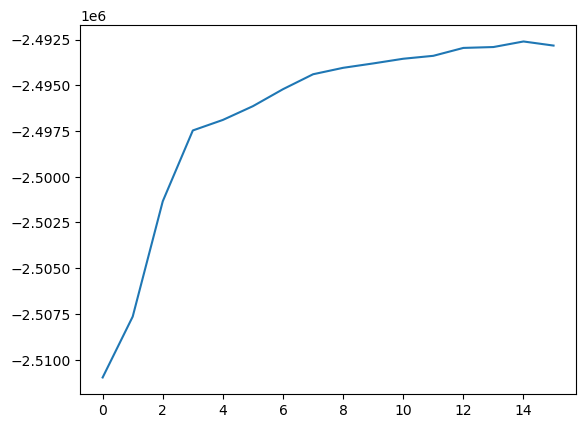

In [19]:
num_trials = 1 # can't currently run more than 1 or overflow GPU memory :( 
num_iters = 300 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
for t in range(num_trials):

    # run coordinate ascent VI
    print(K)

    ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(K, final_data, float_type, hypers = hypers, num_iterations = num_iters)
    elbos_all = np.array(elbos_all)
    juncs_probs = ALPHA_f / (ALPHA_f+PI_f)
    
    theta_f = GAMMA_f / GAMMA_f.sum(1,keepdim=True)
    theta_f_plot = pd.DataFrame(theta_f.cpu())
    theta_f_plot['SMTS'] = cell_ids_conversion["SMTS"].to_numpy()
    theta_f_plot_summ = theta_f_plot.groupby('SMTS').mean()
    print(theta_f_plot_summ)
    
    # plot ELBO
    plt.plot(elbos_all[2:]); plt.show()

In [ ]:
x = theta_f.cpu().numpy()
x -= x.mean(1,keepdims=True)
x /= x.std(1,keepdims=True)
plt.hist(x.flatten(),100)
pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )